In [91]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
import ssl
# creates an SSL context without verifying the authenticity of certificates.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [97]:
df = pd.read_csv('/Users/sofiautoft/research/Recommender_System_TedTalks/tedx_dataset-master/tedx_dataset.csv')
df.head()

,idx,main_speaker,title,details,posted,url,num_views
0,8d2005ec35280deb6a438dc87b225f89,Alexandra Auer,The intangible effects of walls,More barriers exist now than at the end of Wor...,Posted Apr 2020,https://www.ted.com/talks/alexandra_auer_the_i...,NaN
1,b3072cd11f40eb57fd259555264476c6,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...,If you're feeling anxious or fearful during th...,Posted Apr 2020,https://www.ted.com/talks/elizabeth_gilbert_it...,NaN
2,4adc9fee977fa04c357ed4c9b52aa3cc,Butterscotch,"""Accept Who I Am""","Firing off her formidable beatboxing skills, m...",Posted Apr 2020,https://www.ted.com/talks/butterscotch_accept_...,0.0
3,59c641a72b495d522a7932145d6c02b3,Ethan Lisi,What it's really like to have autism,"""Autism is not a disease; it's just another wa...",Posted Apr 2020,https://www.ted.com/talks/ethan_lisi_what_it_s...,NaN
4,d227f2faf6ec185e54436d86463f499b,Daniel Finkel,Can you solve the sea monster riddle?,"According to legend, once every thousand years...",Posted Apr 2020,https://www.ted.com/talks/daniel_finkel_can_yo...,0.0


In [93]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    #Store important words
    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

def cleaning_punctuations(text):
	signal = str.maketrans('', '', punctuations_list)
	return text.translate(signal)

def get_similarities(talk_content, data):

	#Transform talk content into a vector
	talk_array1 = vectorizer.transform(talk_content).toarray()

	#Allocate space to store similarity for each row of the dataset.
	sim = []
	pea = []
	for idx, row in data.iterrows():
		details = row['details']

		# Getting vector for current talk_content.
		talk_array2 = vectorizer.transform(
			data[data['details'] == details]['details']).toarray()

		#Calculate cosine similarities
		cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]

		#Calculate pearson correlation
		pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]

		sim.append(cos_sim)
		pea.append(pea_sim)

	return sim, pea

def recommend_talks(talk_content, data):

	title = [talk_content]
	data['cos_sim'], data['pea_sim'] = get_similarities(title, df)

	data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
					False, False], inplace=True)

	new_df = data[['main_speaker', 'title']]
	print("\033[1m" + "Ted Talks recommended for you since you liked: " + talk_content + "\033[0m")
	for i in range(5):
		print("     Consider the Ted Talk: " + new_df.iloc[i,1] + " by " + new_df.iloc[i, 0])

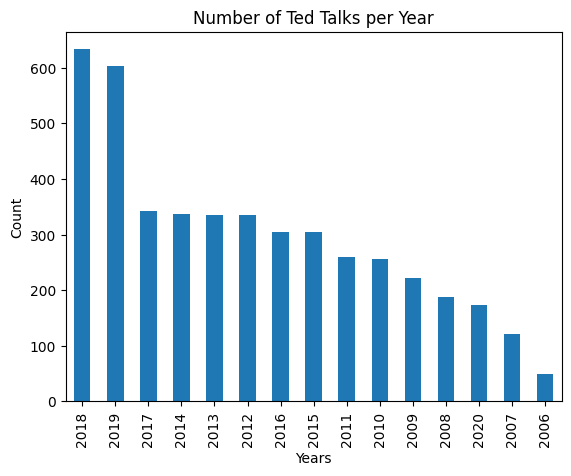

,main_speaker,details,title
0,Alexandra Auer,The intangible effects of walls More barriers ...,The intangible effects of walls
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be...","""Accept Who I Am"""
3,Ethan Lisi,"What it's really like to have autism ""Autism i...",What it's really like to have autism
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...,Can you solve the sea monster riddle?


In [94]:
splitted = df['posted'].str.split(' ', expand=True)

#Create columns for month and year of the talk
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

df['year'].value_counts().plot.bar()
plt.title("Number of Ted Talks per Year")
plt.xlabel("Years")
plt.ylabel("Count")
plt.show()

#Combine the title and the details of the talk.
df['details'] = df['title'] + ' ' + df['details']

# Removing the unnecessary information
data = df[['main_speaker', 'details', 'title']]
data.dropna(inplace = True)

data['details'] = data['details'].apply(lambda text: remove_stopwords(text))

punctuations_list = string.punctuation

data['details'] = data['details'].apply(lambda x: cleaning_punctuations(x))

details_corpus = " ".join(df['details'])

#Capture similarities
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(data['details'])

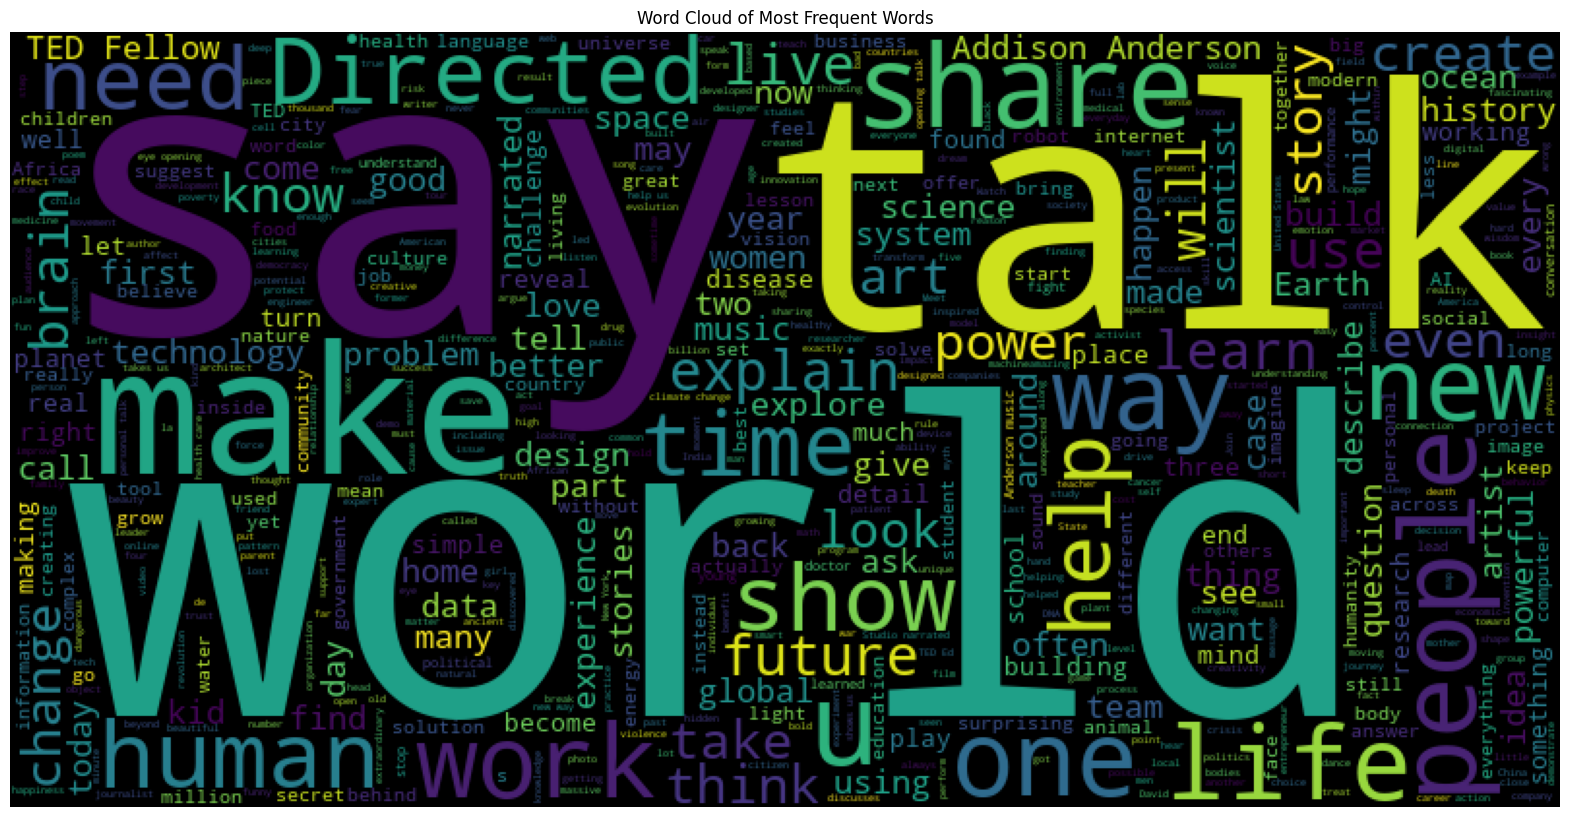

TfidfVectorizer()

In [95]:
#Create word cloud
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, 
			width=800,
			height=400).generate(details_corpus)
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.imshow(wc)
plt.show()

In [101]:
#Get input from user
try:
    theme = input("Enter the theme of the Ted Talk: ")
    recommend_talks(theme, df)
except:
    print("Error.")

Ted Talks recommended for you since you liked: feminism
     Consider the Ted Talk: Tales of passion by Isabel Allende
     Consider the Ted Talk: This isn't her mother's feminism by Courtney E. Martin
     Consider the Ted Talk: What we can learn from the history of feminism by Dolores Huerta
     Consider the Ted Talk: A teen just trying to figure it out by Tavi Gevinson
     Consider the Ted Talk: We should all be feminists by Chimamanda Ngozi Adichie
